## Import Libraries

In [1]:
%matplotlib inline
import gym
import itertools
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import sys
import tensorflow as tf
import collections
import random
import time
import pandas as pd
import sklearn.pipeline
import sklearn.preprocessing
from sklearn.kernel_approximation import RBFSampler
matplotlib.style.use('ggplot')

## Initialize an environment

In [2]:
env = gym.envs.make('Swimmer-v2')
# env = gym.envs.make('Ant-v2')
# env = gym.envs.make('InvertedPendulum-v2')

print(env.observation_space)
print(env.action_space)

observation_sample = np.array([ env.reset() for i in range (10000)])

Box(8,)
Box(2,)


## Feature pre-processing

In [3]:
# Standardization of a dataset: Normalize to mean zero, unit variance
# by using observation_sample
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_sample)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [15]:
# RBFSampler converts a state to it's featurized representation
kernel_featurizer = sklearn.pipeline.FeatureUnion([
        ('rbf1',RBFSampler(gamma=0.5, n_components=200)),
        ('rbf2',RBFSampler(gamma=1.0, n_components=200)),
        ('rbf3',RBFSampler(gamma=2.0, n_components=200)),
        ('rbf4',RBFSampler(gamma=5, n_components=200))
        ])
kernel_featurizer.fit(scaler.transform(observation_sample))
def state_featurize(state):
    """
    Driver method to return featurized state.
    """
    state_scaled = scaler.transform([state])
    featurized = kernel_featurizer.transform(state_scaled)
    return featurized[0]

## Estimator initialization

In [9]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.005, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, shape = (800,), name = "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # Linear Classifier 
            # mu and sigma to create normal distribution
            self.mu = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
           
            self.mu = tf.squeeze(self.mu)
            
            self.sigma = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)
            
            self.sigma = tf.squeeze(self.sigma)
            self.sigma = tf.nn.softplus(self.sigma) + 1e-5
            
            self.normal_dist = tf.contrib.distributions.Normal(self.mu, self.sigma)
            
            self.action = self.normal_dist._sample_n(1)

            # Loss and train op
            self.loss = -self.normal_dist.log_prob(self.action) * self.target
            
            # Add cross entropy cost to encourage exploration
            self.loss -= 1e-1 * self.normal_dist.entropy()
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = state_featurize(state)
        return sess.run(self.action, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        state = state_featurize(state)
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [10]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.float32, shape = (800,), name ="state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # Linear Classifier 
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(self.state, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        state = state_featurize(state)
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        state = state_featurize(state)
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

## Actor-Critic algorithm

In [11]:
def actor_critic(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    print(discount_factor)
    """
    Actor Critic Algorithm.
    
    Args:
        env: Gym environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a critic
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An object with 4 numpy arrays for episode_lengths, episode_rewards, value_loos, and policy_loss.
    """
    
    # Keeps track of training information
    EpisodeStats = collections.namedtuple("Stats",["episode_lengths", "episode_rewards"])
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    value_loss_array = []
    policy_loss_array = []
    
    for i_episode in range(num_episodes):
        
        state = env.reset()

        for t in itertools.count():
            
            env.render()
            
            # Take a step according to the action
            action = estimator_policy.predict(state)
            next_state, reward, done, _ = env.step(action)
            
            # Update info
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Calculate TD target
            value_next = estimator_value.predict(next_state)
            td_target = reward + discount_factor * value_next
            td_error = td_target - estimator_value.predict(state)
            
            # Update the value estimator
            value_loss = estimator_value.update(state, td_target) 
            
            # Update info
            value_loss_array.append(value_loss)
            
            # Update the policy estimator
            # using TD error as the advantage estimate
            policy_loss = estimator_policy.update(state, td_error, action)
            
            # Update info
            policy_loss_array.append(policy_loss)
            
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")

            if done:
                break
                
            state = next_state
    return stats,value_loss_array,policy_loss_array

## Main

In [16]:
tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.005)
value_estimator = ValueEstimator(learning_rate=0.1)

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats = actor_critic(env, policy_estimator, value_estimator, 100 , discount_factor=0.9)
    env.close()

0.9
Step 999 @ Episode 100/100 (0.5268842305348094)4)

## Plotting Part

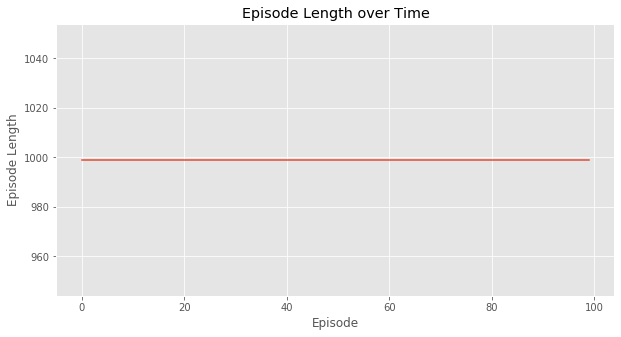

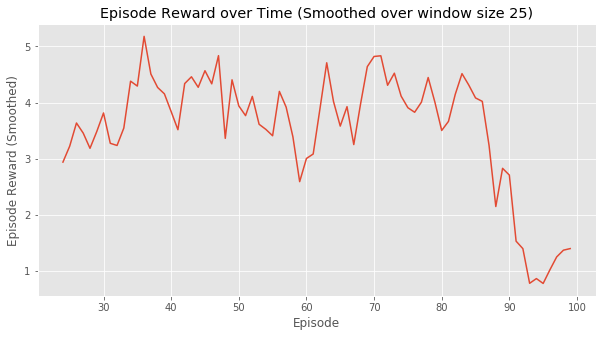

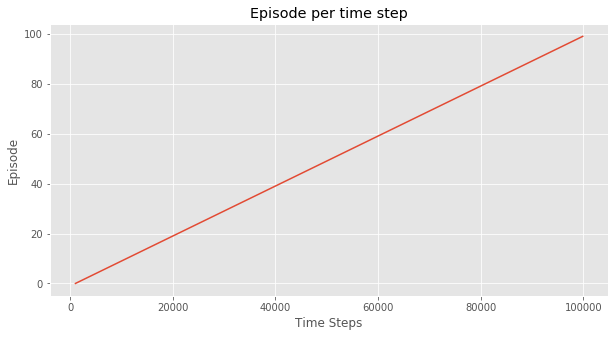

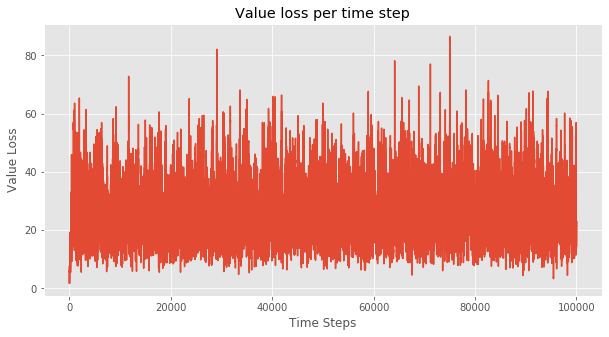

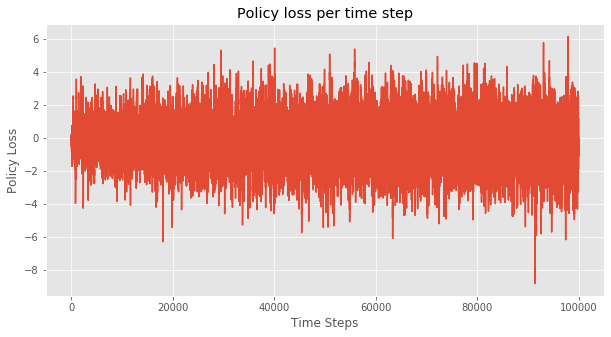

In [17]:
smoothing_window = 25
episode_lengths = stats[0][0]
episode_rewards = stats[0][1]
fig1 = plt.figure(figsize=(10,5))
plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("Episode Length over Time")
plt.show(fig1)

# Plot the episode reward over time
fig2 = plt.figure(figsize=(10,5))
rewards_smoothed = pd.Series(episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
plt.plot(rewards_smoothed)
plt.xlabel("Episode")
plt.ylabel("Episode Reward (Smoothed)")
plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
plt.show(fig2)

# Plot time steps and episode number
fig3 = plt.figure(figsize=(10,5))
plt.plot(np.cumsum(episode_lengths), np.arange(len(episode_lengths)))
plt.xlabel("Time Steps")
plt.ylabel("Episode")
plt.title("Episode per time step")
plt.show(fig3)

# Plot value_loss and episode number
fig4 = plt.figure(figsize=(10,5))
value_loss_smoothed = pd.Series(stats[1]).rolling(25, min_periods=25).mean()
plt.plot(value_loss_smoothed)
plt.xlabel("Time Steps")
plt.ylabel("Value Loss")
plt.title("Value loss per time step")
plt.show(fig4)

# Plot policy_loss and episode number
fig5 = plt.figure(figsize=(10,5))
value_loss_smoothed = pd.Series(stats[2]).rolling(25, min_periods=25).mean()
plt.plot(value_loss_smoothed)
plt.xlabel("Time Steps")
plt.ylabel("Policy Loss")
plt.title("Policy loss per time step")
plt.show(fig5)


